In [ ]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from IPython.display import Image
import imutils
from sklearn.utils import shuffle
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import PIL
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
import os
# Create a directory for Kaggle
os.makedirs('/root/.kaggle', exist_ok=True)
# Move the kaggle.json file to the appropriate directory
!mv kaggle.json /root/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
!unzip ct-kidney-dataset-normal-cyst-tumor-and-stone.zip

Streaming output truncated to the last 5000 lines.
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4363).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4364).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4365).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4366).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4367).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4368).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4369).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-N

In [ ]:
import os
import shutil
import random

# Define correct source directory
source_dir = "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

# Use correct category names from the dataset
categories = ["Cyst", "Tumor", "Stone", "Normal"]  # Match capitalization

# Define dataset split folders
base_dir = "/content/dataset"
train_dir = os.path.join(base_dir, "training")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "testing")

# Create directories for train, val, test with category subfolders
for dataset in [train_dir, val_dir, test_dir]:
    os.makedirs(dataset, exist_ok=True)
    for category in categories:
        os.makedirs(os.path.join(dataset, category), exist_ok=True)

# Move images into train, val, test (80-10-10 split)
for category in categories:
    category_path = os.path.join(source_dir, category)

    if not os.path.exists(category_path):
        print(f" Skipping {category}, directory not found! ({category_path})")
        continue

    images = [img for img in os.listdir(category_path) if img.endswith(('.png', '.jpg', '.jpeg'))]

    if len(images) == 0:
        print(f" No images found in {category_path}!")
        continue

    random.shuffle(images)  # Shuffle images

    # Define split sizes
    total_images = len(images)
    train_split = int(0.8 * total_images)  # 80% training
    val_split = int(0.9 * total_images)  # 10% validation, 10% testing

    # Move images
    for i, img in enumerate(images):
        src_path = os.path.join(category_path, img)

        if i < train_split:
            dst_path = os.path.join(train_dir, category, img)
        elif i < val_split:
            dst_path = os.path.join(val_dir, category, img)
        else:
            dst_path = os.path.join(test_dir, category, img)

        shutil.move(src_path, dst_path)

    print(f"{category}: {train_split} (train), {val_split - train_split} (val), {total_images - val_split} (test)")

print("\n Dataset successfully organized into train, val, and test folders!")


Cyst: 2967 (train), 371 (val), 371 (test)
Tumor: 1826 (train), 228 (val), 229 (test)
Stone: 1101 (train), 138 (val), 138 (test)
Normal: 4061 (train), 508 (val), 508 (test)

 Dataset successfully organized into train, val, and test folders!


In [ ]:
classes = os.listdir("/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone")

classes

['Tumor', 'Cyst', 'Stone', 'Normal']

Total Cyst images selected: 15
Total Tumor images selected: 15
Total Stone images selected: 15
Total Normal images selected: 15


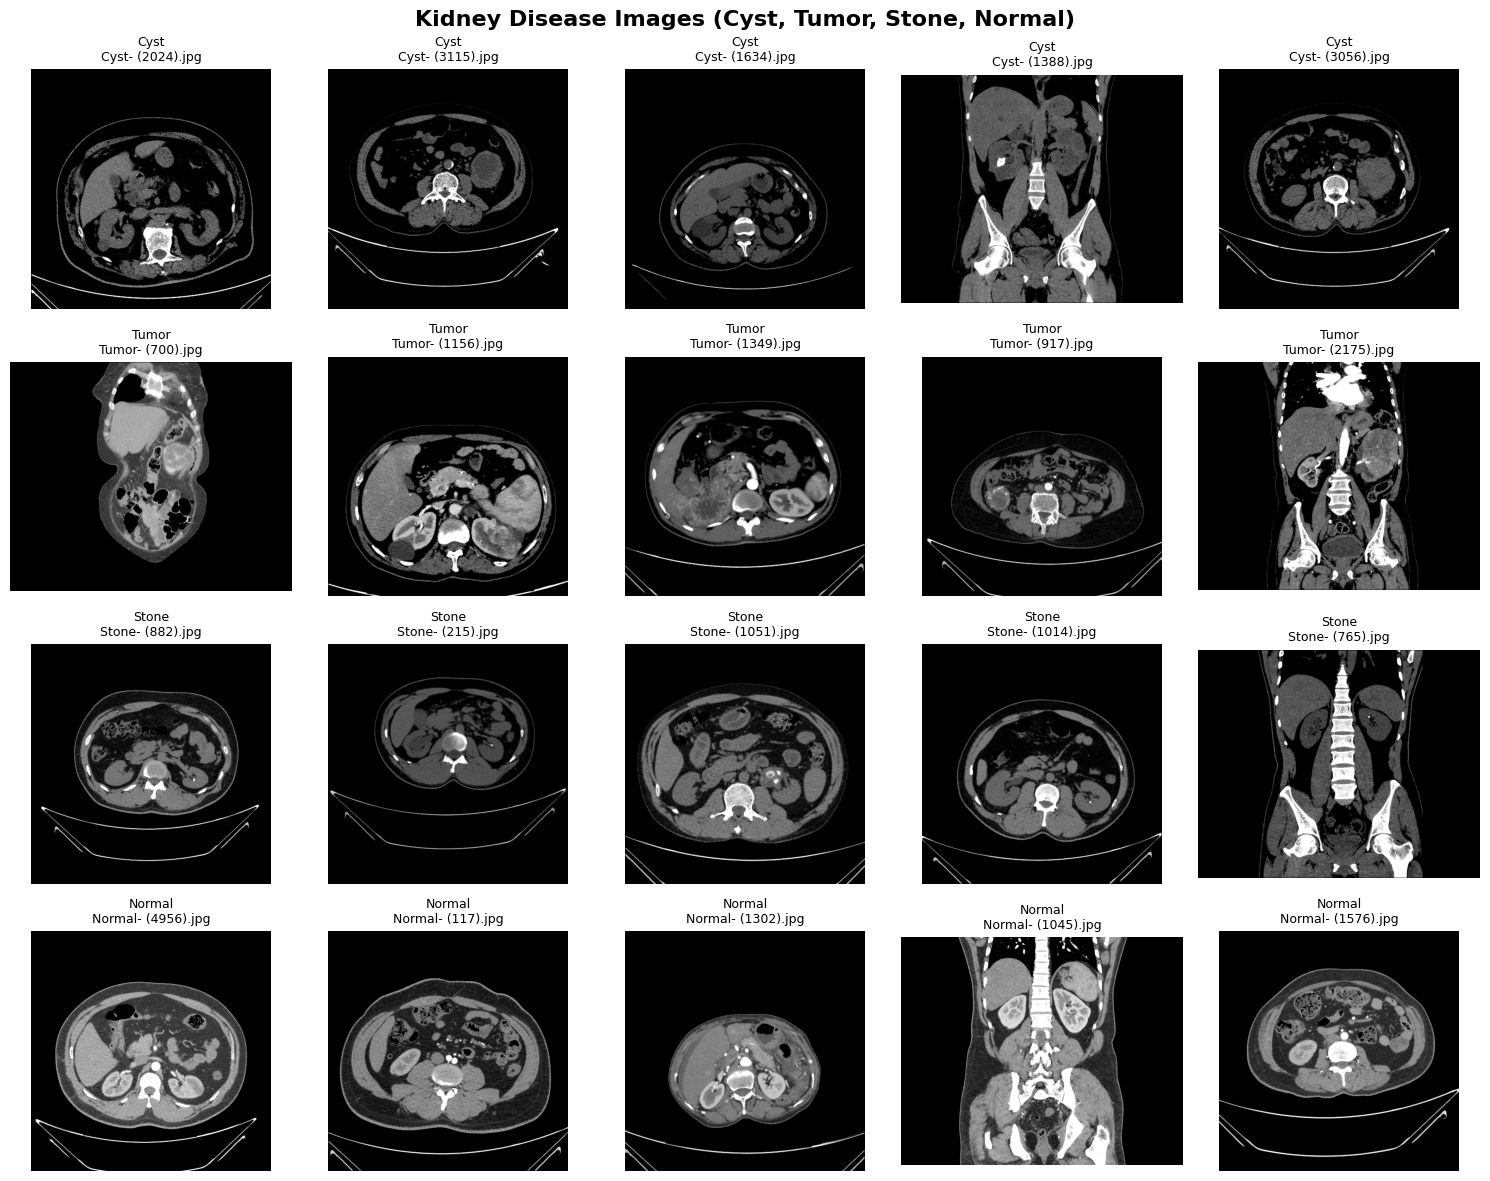

In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define dataset directories
dataset_dirs = [
    "/content/dataset/training",
    "/content/dataset/validation",
    "/content/dataset/testing"
]

# Categories in the dataset
categories = ["Cyst", "Tumor", "Stone", "Normal"]

# Dictionary to store selected images
selected_images = {category: [] for category in categories}

# Collect images from each dataset directory
for directory in dataset_dirs:
    if os.path.exists(directory):
        for category in categories:
            category_path = os.path.join(directory, category)
            if os.path.exists(category_path):
                images = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
                random.shuffle(images)  # Shuffle images
                selected_images[category].extend(images[:5])  # Select 5 images from each category

# Debugging: Check the number of images collected
for category in categories:
    print(f"Total {category} images selected:", len(selected_images[category]))

# Ensure we have enough images to display
if any(len(selected_images[cat]) < 5 for cat in categories):
    print("Error: Not enough images found for one or more categories.")
else:
    # Flatten selected images into a list
    all_images = []
    labels = []
    for category in categories:
        all_images.extend(selected_images[category][:5])
        labels.extend([category] * 5)

    # Set grid size (4 rows × 5 columns)
    rows, cols = 4, 5
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

    # Plot images in a grid
    for i, ax in enumerate(axes.flat):
        if i < len(all_images):
            img_path = all_images[i]
            img = cv2.imread(img_path)  # Read image
            if img is None:
                print(f"Error loading image: {img_path}")
                ax.axis('off')
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            ax.imshow(img)
            ax.set_title(f"{labels[i]}\n{os.path.basename(img_path)}", fontsize=9)  # Show category & filename
            ax.axis('off')  # Hide axes
        else:
            ax.axis('off')  # Hide unused subplots

    # Adjust layout
    plt.suptitle("Kidney Disease Images (Cyst, Tumor, Stone, Normal)", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


In [ ]:
import os
import numpy as np
from imutils import paths
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Hyperparameters
NUM_EPOCHS = 30
INIT_LR = 1e-2
BS = 32

# Define dataset paths
train_dir = "/content/dataset/training"
val_dir = "/content/dataset/validation"
test_dir = "/content/dataset/testing"

# Count total images
trainPaths = list(paths.list_images(train_dir))
totalTrain = len(trainPaths)
totalVal = len(list(paths.list_images(val_dir)))
totalTest = len(list(paths.list_images(test_dir)))

# Extract labels from directory names
trainLabels = [p.split(os.path.sep)[-2] for p in trainPaths]

# Convert labels to categorical format
unique_classes = sorted(set(trainLabels))
class_indices = {cls: idx for idx, cls in enumerate(unique_classes)}
trainLabels = np.array([class_indices[label] for label in trainLabels])
trainLabels = to_categorical(trainLabels, num_classes=len(unique_classes))

# Compute class weights for imbalanced datasets
classTotals = trainLabels.sum(axis=0)
classWeight = classTotals.max() / classTotals

# Data augmentation for training
trainAug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and testing
valAug = ImageDataGenerator(rescale=1./255)

# Create data generators
trainGen = trainAug.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # Resize images
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

valGen = valAug.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

testGen = valAug.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Print class mappings
print(f"Class Indices: {trainGen.class_indices}")


Found 9955 images belonging to 4 classes.
Found 1245 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.
Class Indices: {'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}


In [ ]:
import warnings
warnings.filterwarnings("ignore")

ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained ResNet50 model as base (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Changed to (224, 224, 3)

# Unfreeze some layers for fine-tuning
base_model.trainable = True
fine_tune_at = 100  # Fine-tune from this layer onward
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Add custom layers on top of the pre-trained model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(4, activation='softmax')(x)  # 4 classes

# Define the new model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary for verification
model.summary()

# Define the image data generator with proper resizing
trainAug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valAug = ImageDataGenerator(rescale=1./255)

# Create data generators with resized images
trainGen = trainAug.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize to (224, 224)
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

valGen = valAug.flow_from_directory(
    val_dir,
    target_size=(224, 224),  # Resize to (224, 224)
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint("kidney_model_resnet50.h5", save_best_only=True, monitor="val_loss", mode="min", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Train the model
history = model.fit(
    trainGen,
    validation_data=valGen,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 20,504,068 (78.22 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

Found 9955 images belonging to 4 classes.
Found 1245 images belonging to 4 classes.
Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.6248 - loss: 0.9414
Epoch 1: val_loss improved from inf to 0.56191, saving model to kidney_model_resnet50.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 208s 554ms/step - accuracy: 0.6250 - loss: 0.9408 - val_accuracy: 0.8008 - val_loss: 0.5619 - learning_rate: 1.0000e-04
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.7935 - loss: 0.5227
Epoch 2: val_loss improved from 0.56191 to 0.52580, saving model to kidney_model_resnet50.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 169s 501ms/step - accuracy: 0.7935 - loss: 0.5226 - val_accuracy: 0.8201 - val_loss: 0.5258 - learning_rate: 1.0000e-04
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8560 - loss: 0.3771
Epoch 3: val_loss improved from 0.52580 to 0.41256, saving model to kidney_model_resnet50.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 152s 488ms/step - accuracy: 0.8560 - loss: 0.3772 - val_accuracy: 0.8514 - val_loss: 0.4126 - learning_rate: 1.0000e-04
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.8837 - loss: 0.2954
Epoch 4: val_loss improved from 0.41256 to 0.22746, saving model to kidney_model_resnet50.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 155s 498ms/step - accuracy: 0.8837 - loss: 0.2954 - val_accuracy: 0.9076 - val_loss: 0.2275 - learning_rate: 1.0000e-04
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.9018 - loss: 0.2515
Epoch 5: val_loss improved from 0.22746 to 0.16922, saving model to kidney_model_resnet50.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 157s 502ms/step - accuracy: 0.9018 - loss: 0.2515 - val_accuracy: 0.9317 - val_loss: 0.1692 - learning_rate: 1.0000e-04
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9198 - loss: 0.2212
Epoch 6: val_loss did not improve from 0.16922
312/312 ━━━━━━━━━━━━━━━━━━━━ 151s 483ms/step - accuracy: 0.9198 - loss: 0.2212 - val_accuracy: 0.8787 - val_loss: 0.3896 - learning_rate: 1.0000e-04
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9231 - loss: 0.2130
Epoch 7: val_loss did not improve from 0.16922
312/312 ━━━━━━━━━━━━━━━━━━━━ 150s 479ms/step - accuracy: 0.9231 - loss: 0.2129 - val_accuracy: 0.9253 - val_loss: 0.2292 - learning_rate: 1.0000e-04
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9332 - loss: 0.1696
Epoch 8: val_loss did not improve from 0.16922

Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
312/312 ━━━━━━━━━━━━━━━━━━━━ 202s 480ms/step - accuracy: 0.9332 - loss:

In [13]:

# Method 1: Display Training and Validation Accuracy
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Method 2: Display Test Accuracy
test_loss, test_accuracy = model.evaluate(testGen)  # Evaluate the model on the test set
print(f"Test Accuracy: {test_accuracy:.4f}")

# Method 3: Compute Classification Metrics
import numpy as np
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Get true labels and predicted labels
y_true = testGen.classes  # True labels from the test set
y_pred = np.argmax(model.predict(testGen), axis=1)  # Predicted labels

# Display classification report
report = classification_report(y_true, y_pred, target_names=list(testGen.class_indices.keys()))
print("Classification Report:")
print(report)

# Compute and display overall Precision, Recall, and F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1-Score: {f1:.4f}")


Final Training Accuracy: 0.9688
Final Validation Accuracy: 0.9325
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.9601 - loss: 0.1139
Test Accuracy: 0.9350
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step
Classification Report:
              precision    recall  f1-score   support

        Cyst       0.92      0.97      0.94       371
      Normal       0.96      0.97      0.96       508
       Stone       0.93      0.73      0.82       138
       Tumor       0.91      0.93      0.92       229

    accuracy                           0.93      1246
   macro avg       0.93      0.90      0.91      1246
weighted avg       0.94      0.93      0.93      1246

Overall Precision: 0.9351
Overall Recall: 0.9350
Overall F1-Score: 0.9335


39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step

Classification Report:
               precision    recall  f1-score   support

        Cyst       0.92      0.97      0.94       371
       Tumor       0.96      0.97      0.96       508
       Stone       0.93      0.73      0.82       138
      Normal       0.91      0.93      0.92       229

    accuracy                           0.93      1246
   macro avg       0.93      0.90      0.91      1246
weighted avg       0.94      0.93      0.93      1246


Macro Average Metrics:
Precision (Macro): 0.9295
Recall (Macro): 0.8997
F1 Score (Macro): 0.9116

Micro Average Metrics:
Precision (Micro): 0.9350
Recall (Micro): 0.9350
F1 Score (Micro): 0.9350

Matthews Correlation Coefficient (MCC): 0.9070

AUC-ROC (Macro Average): 0.9943


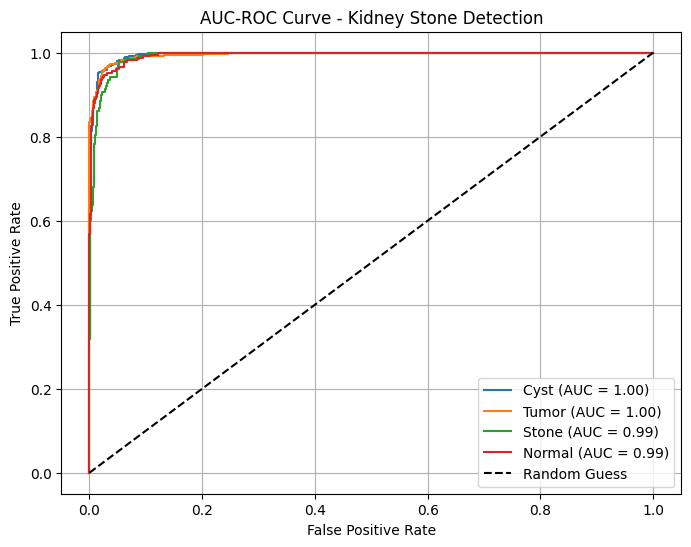

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve, auc

# Get true labels and predicted labels
y_true = testGen.classes  # True labels from test data
y_pred_probs = model.predict(testGen)  # Get probability outputs
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

# Classification Report
class_labels = ["Cyst", "Tumor", "Stone", "Normal"]  # Labels for kidney stone dataset
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\nClassification Report:\n", report)

# Compute Precision, Recall, F1-score (Macro & Micro Average)
precision_macro = precision_score(y_true, y_pred, average="macro")
recall_macro = recall_score(y_true, y_pred, average="macro")
f1_macro = f1_score(y_true, y_pred, average="macro")

precision_micro = precision_score(y_true, y_pred, average="micro")
recall_micro = recall_score(y_true, y_pred, average="micro")
f1_micro = f1_score(y_true, y_pred, average="micro")

print(f"\nMacro Average Metrics:")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")

print(f"\nMicro Average Metrics:")
print(f"Precision (Micro): {precision_micro:.4f}")
print(f"Recall (Micro): {recall_micro:.4f}")
print(f"F1 Score (Micro): {f1_micro:.4f}")

# Compute MCC (Matthews Correlation Coefficient)
mcc = matthews_corrcoef(y_true, y_pred)
print(f"\nMatthews Correlation Coefficient (MCC): {mcc:.4f}")

# Compute AUC-ROC Curve
y_true_one_hot = np.eye(len(class_labels))[y_true]  # Convert y_true to one-hot encoding
auc_roc_macro = roc_auc_score(y_true_one_hot, y_pred_probs, average="macro", multi_class="ovr")
print(f"\nAUC-ROC (Macro Average): {auc_roc_macro:.4f}")

# Plot AUC-ROC Curve
plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve - Kidney Stone Detection")
plt.legend(loc="lower right")
plt.grid()
plt.savefig("kidney_auc_roc_curve.jpg", dpi=300)  # Save as JPG
plt.show()


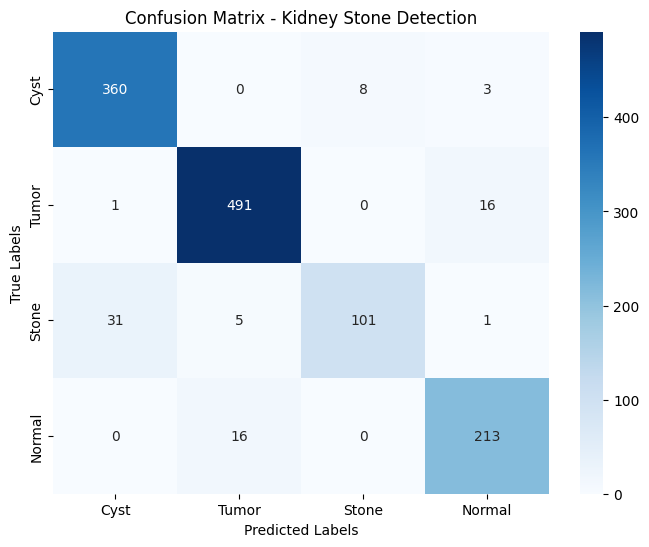

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Kidney Stone Detection")
plt.savefig("confusion_matrix.jpg", dpi=300)  # Save as JPG
plt.show()

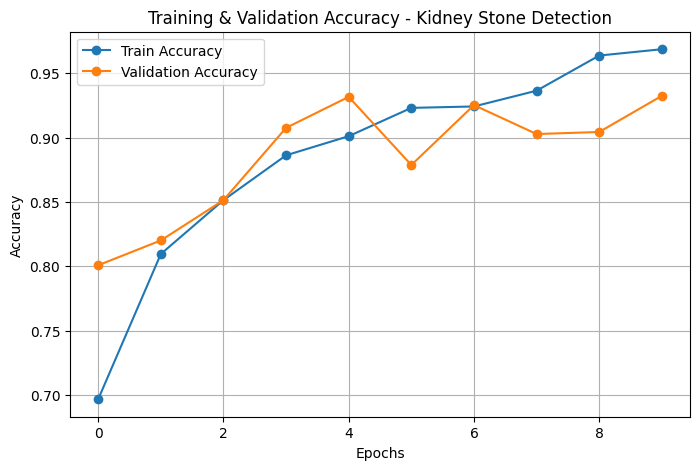

In [16]:
# Plot Training & Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy - Kidney Stone Detection")
plt.legend()
plt.grid()
plt.savefig("training_accuracy.jpg", dpi=300)  # Save as JPG
plt.show()

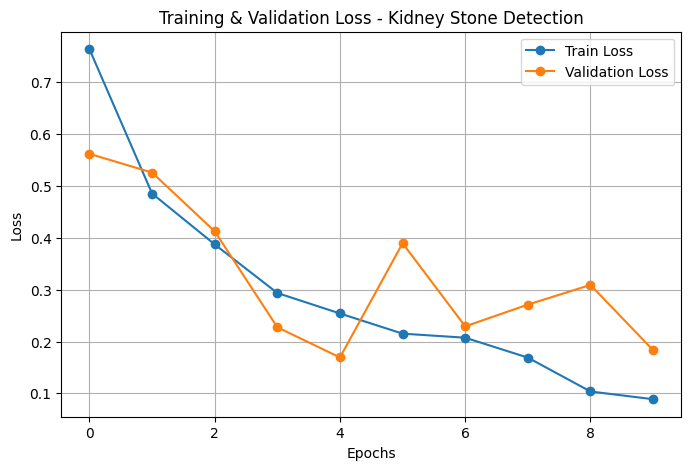


All performance metrics and graphs for kidney stone classification are displayed successfully and saved as JPG files!


In [17]:
# Plot Training & Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss - Kidney Stone Detection")
plt.legend()
plt.grid()
plt.savefig("training_loss.jpg", dpi=300)  # Save as JPG
plt.show()

print("\nAll performance metrics and graphs for kidney stone classification are displayed successfully and saved as JPG files!")



Plot saved as 'plot.png'


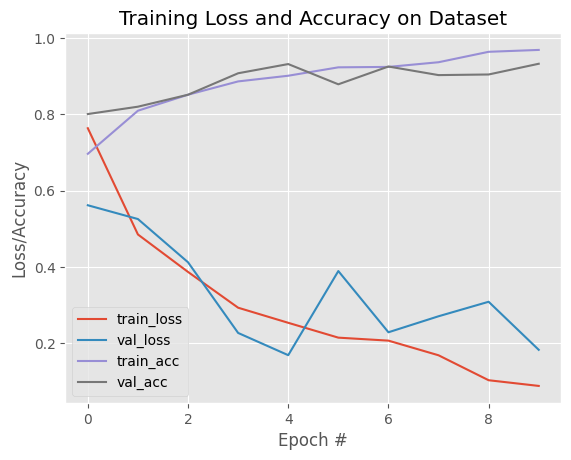

In [18]:
# Plot Loss & Accuracy
plt.style.use("ggplot")
plt.figure()
N = len(history.history["loss"])
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

print("\nPlot saved as 'plot.png'")

Please upload a kidney scan for prediction


Saving WhatsApp Image 2025-03-20 at 3.15.53 PM.jpeg to WhatsApp Image 2025-03-20 at 3.15.53 PM.jpeg


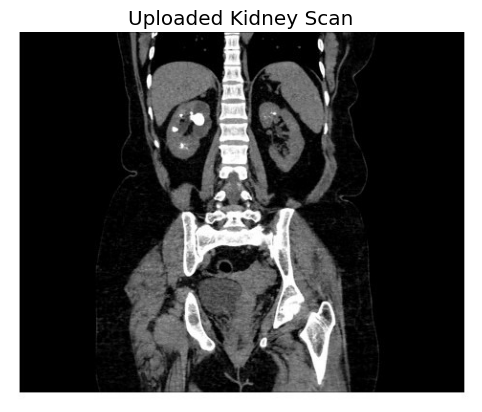

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: Stone
Confidence: 84.68%


In [20]:
import tensorflow as tf
import numpy as np
import cv2
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
def load_model():
    model = tf.keras.models.load_model("/content/kidney_model_resnet50.h5")  # Update with correct model file
    return model

model = load_model()

# Function to preprocess image
def preprocess_image(image):
    image = np.array(image)
    image = cv2.resize(image, (224, 224))  # Resize to match model input
    image = image.astype("float32") / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Define class labels for Kidney Stone Detection
class_labels = ["Cyst", "Tumor", "Stone", "Normal"]

# Upload an image
print("Please upload a kidney scan for prediction")
uploaded = files.upload()

for filename in uploaded.keys():
    image = Image.open(filename).convert("RGB")

    # Display the uploaded image
    plt.imshow(image)
    plt.axis("off")
    plt.title("Uploaded Kidney Scan")
    plt.show()

    # Preprocess the image
    processed_image = preprocess_image(image)

    # Make prediction
    prediction = model.predict(processed_image)
    class_idx = np.argmax(prediction)
    result = class_labels[class_idx]
    confidence = prediction[0][class_idx] * 100

    print(f"Prediction: {result}")
    print(f"Confidence: {confidence:.2f}%")


Please upload a kidney scan for prediction


Saving Tumor- (1436).jpg to Tumor- (1436) (1).jpg


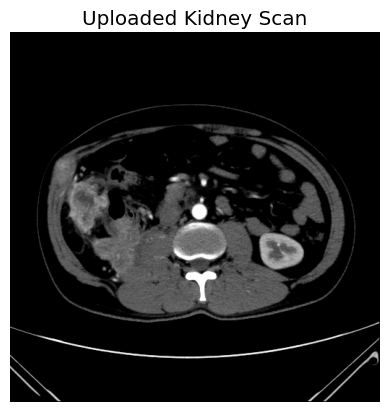

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: Normal
Confidence: 98.18%


In [23]:
import tensorflow as tf
import numpy as np
import cv2
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
def load_model():
    model = tf.keras.models.load_model("/content/kidney_model_resnet50.h5")  # Update with correct model file
    return model

model = load_model()

# Function to preprocess image
def preprocess_image(image):
    image = np.array(image)
    image = cv2.resize(image, (224, 224))  # Resize to match model input
    image = image.astype("float32") / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Define class labels for Kidney Stone Detection
class_labels = ["Cyst", "Tumor", "Stone", "Normal"]

# Upload an image
print("Please upload a kidney scan for prediction")
uploaded = files.upload()

for filename in uploaded.keys():
    image = Image.open(filename).convert("RGB")

    # Display the uploaded image
    plt.imshow(image)
    plt.axis("off")
    plt.title("Uploaded Kidney Scan")
    plt.show()

    # Preprocess the image
    processed_image = preprocess_image(image)

    # Make prediction
    prediction = model.predict(processed_image)
    class_idx = np.argmax(prediction)
    result = class_labels[class_idx]
    confidence = prediction[0][class_idx] * 100

    print(f"Prediction: {result}")
    print(f"Confidence: {confidence:.2f}%")


Please upload a kidney scan for prediction


Saving Stone- (117).jpg to Stone- (117).jpg


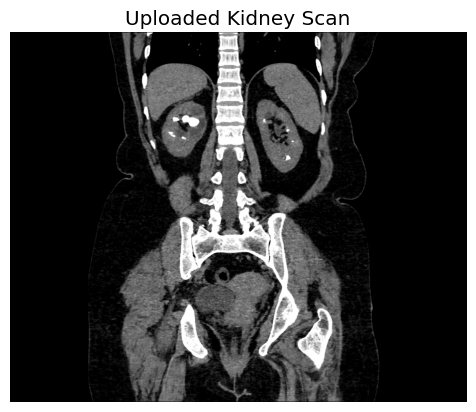

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: Stone
Confidence: 93.84%


In [25]:
import tensorflow as tf
import numpy as np
import cv2
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
def load_model():
    model = tf.keras.models.load_model("/content/kidney_model_resnet50.h5")  # Update with correct model file
    return model

model = load_model()

# Function to preprocess image
def preprocess_image(image):
    image = np.array(image)
    image = cv2.resize(image, (224, 224))  # Resize to match model input
    image = image.astype("float32") / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Define class labels for Kidney Stone Detection
class_labels = ["Cyst", "Tumor", "Stone", "Normal"]

# Upload an image
print("Please upload a kidney scan for prediction")
uploaded = files.upload()

for filename in uploaded.keys():
    image = Image.open(filename).convert("RGB")

    # Display the uploaded image
    plt.imshow(image)
    plt.axis("off")
    plt.title("Uploaded Kidney Scan")
    plt.show()

    # Preprocess the image
    processed_image = preprocess_image(image)

    # Make prediction
    prediction = model.predict(processed_image)
    class_idx = np.argmax(prediction)
    result = class_labels[class_idx]
    confidence = prediction[0][class_idx] * 100

    print(f"Prediction: {result}")
    print(f"Confidence: {confidence:.2f}%")


Please upload a kidney scan for prediction


Saving Normal- (1255).jpg to Normal- (1255).jpg


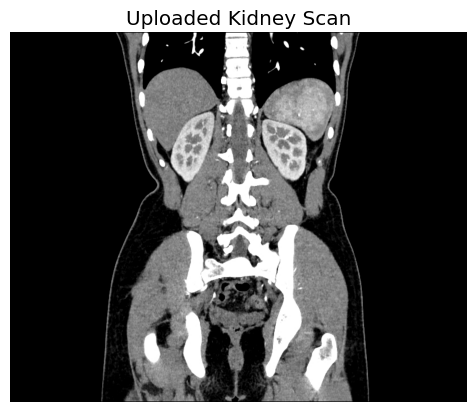

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: Tumor
Confidence: 98.17%


In [26]:
import tensorflow as tf
import numpy as np
import cv2
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
def load_model():
    model = tf.keras.models.load_model("/content/kidney_model_resnet50.h5")  # Update with correct model file
    return model

model = load_model()

# Function to preprocess image
def preprocess_image(image):
    image = np.array(image)
    image = cv2.resize(image, (224, 224))  # Resize to match model input
    image = image.astype("float32") / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Define class labels for Kidney Stone Detection
class_labels = ["Cyst", "Tumor", "Stone", "Normal"]

# Upload an image
print("Please upload a kidney scan for prediction")
uploaded = files.upload()

for filename in uploaded.keys():
    image = Image.open(filename).convert("RGB")

    # Display the uploaded image
    plt.imshow(image)
    plt.axis("off")
    plt.title("Uploaded Kidney Scan")
    plt.show()

    # Preprocess the image
    processed_image = preprocess_image(image)

    # Make prediction
    prediction = model.predict(processed_image)
    class_idx = np.argmax(prediction)
    result = class_labels[class_idx]
    confidence = prediction[0][class_idx] * 100

    print(f"Prediction: {result}")
    print(f"Confidence: {confidence:.2f}%")


Please upload a kidney scan for prediction


Saving Cyst- (1070).jpg to Cyst- (1070).jpg


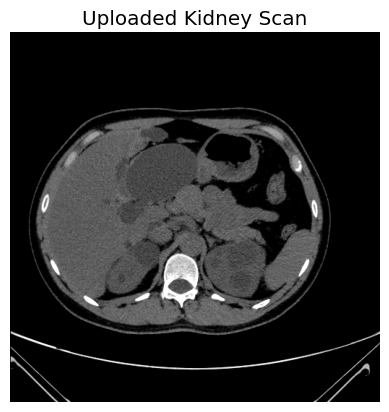

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: Cyst
Confidence: 99.77%


In [27]:
import tensorflow as tf
import numpy as np
import cv2
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
def load_model():
    model = tf.keras.models.load_model("/content/kidney_model_resnet50.h5")  # Update with correct model file
    return model

model = load_model()

# Function to preprocess image
def preprocess_image(image):
    image = np.array(image)
    image = cv2.resize(image, (224, 224))  # Resize to match model input
    image = image.astype("float32") / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Define class labels for Kidney Stone Detection
class_labels = ["Cyst", "Tumor", "Stone", "Normal"]

# Upload an image
print("Please upload a kidney scan for prediction")
uploaded = files.upload()

for filename in uploaded.keys():
    image = Image.open(filename).convert("RGB")

    # Display the uploaded image
    plt.imshow(image)
    plt.axis("off")
    plt.title("Uploaded Kidney Scan")
    plt.show()

    # Preprocess the image
    processed_image = preprocess_image(image)

    # Make prediction
    prediction = model.predict(processed_image)
    class_idx = np.argmax(prediction)
    result = class_labels[class_idx]
    confidence = prediction[0][class_idx] * 100

    print(f"Prediction: {result}")
    print(f"Confidence: {confidence:.2f}%")


In [29]:
# Save the trained model
model.save("kidney_model_resnet50.h5")
print("Model saved as kidney_model_resnet50.h5")


Model saved as kidney_model_resnet50.h5
